In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm

import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
    
from solardatatools.solar_noon import energy_com

# for CVXPY implementation
from solardatatools.signal_decompositions import l2_l1d1_l2d2p365 as cvx_sd
from solardatatools.signal_decompositions_l2norm import l2_l1d1_l2d2p365 as cvx_sd_l2norm

# for OSD implementation
from solardatatools.osd_signal_decompositions import l2_l1d1_l2d2p365 as osd_sd
from gfosd.components import *
from gfosd import Problem

# Import data from `tests/fixtures`

In [3]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

input_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_with_shift.csv")
with open(input_power_signals_file_path) as file:
    power_data_matrix = np.loadtxt(file, delimiter=",")

use_days_file_path = Path(fixtures_path + "time_shifts/clear_days.csv")
with open(use_days_file_path) as file:
    use_days = np.loadtxt(file, delimiter=",")

output_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_fixed.csv")
with open(output_power_signals_file_path) as file:
    expected_power_data_fix = np.loadtxt(file, delimiter=",")

## Preprocess data to obtain metric

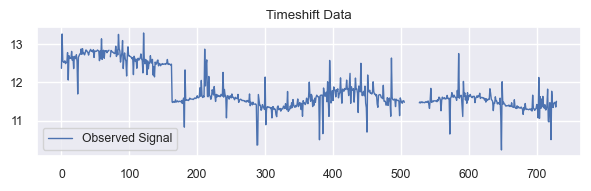

In [3]:
# Estimate solar noon
metric = energy_com(power_data_matrix)   # does not depend on any SDs
use_ixs = np.logical_and(use_days, ~np.isnan(metric))

# plot observed
f, ax = plt.subplots(1, 1, figsize=(6,2))
ax.plot(metric, linewidth=1, label="Observed Signal");
ax.set_title("Timeshift Data")
plt.tight_layout()
ax.legend()

# Current state: c1 optimized, c2=200

MAE s_hat  (OSD,CVX)   1.79e-02
MAE s_seas (OSD,CVX)   2.42e-02


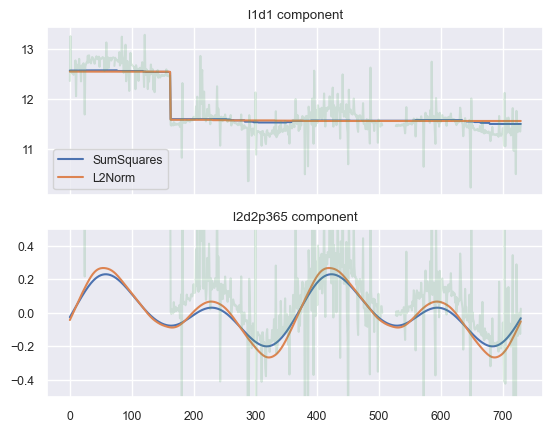

In [21]:
cvx_ss = cvx_sd(metric, c1=6, c2=5e5, use_ixs=use_ixs, solver="MOSEK")

# approximate c1 weight from optimization  in module (c2 is fixed)
cvx_l2n = cvx_sd_l2norm(metric, c1=6, c2=200, use_ixs=use_ixs, solver="MOSEK")

print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss[0], cvx_l2n[0]):.2e}')
print(f'MAE s_seas (OSD,CVX)   {mae(cvx_ss[1], cvx_l2n[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(cvx_ss[0], label="SumSquares")
ax1.plot(cvx_l2n[0], label="L2Norm")
ax1.plot(metric, alpha=0.2)
ax1.set_title("l1d1 component")
ax2.plot(cvx_ss[1])
ax2.plot(cvx_l2n[1])
ax2.plot(metric-metric[-3], alpha=0.2)
ax2.set_ylim(-0.5, 0.5)
ax2.set_title("l2d2p365 component")
ax1.legend()
plt.show()

# Optimize c2 only here for now? (not using SumCard yet)

In [47]:
results = {}
weight_iter = np.logspace(4.35, 4.5, 50)

def run(sig):
    mse_list = []
    for w in tqdm(weight_iter):
        res = cvx_sd(metric, c1=6, c2=w, use_ixs=use_ixs, solver="MOSEK")
        mse_list.append(mse(cvx_l2n[1], res[1], squared=False))
        
    results["weight_min"] =  weight_iter[np.argmin(mse_list)]
    results["mse_min"] = np.min(mse_list)
    results["mse_list"] = mse_list

In [48]:
run(metric)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.78it/s]


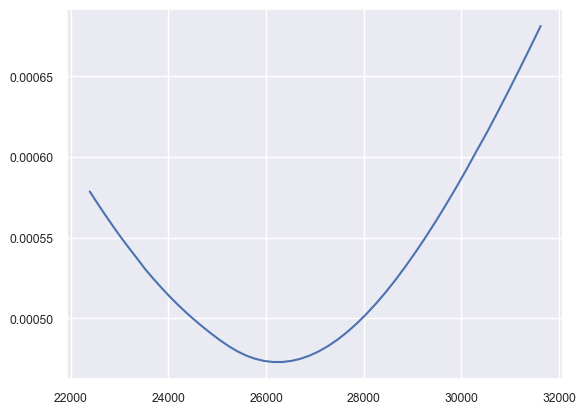

In [49]:
plt.plot(weight_iter, results["mse_list"])

MAE s_hat  (OSD,CVX)   6.03e-04
MAE s_seas (OSD,CVX)   4.17e-04


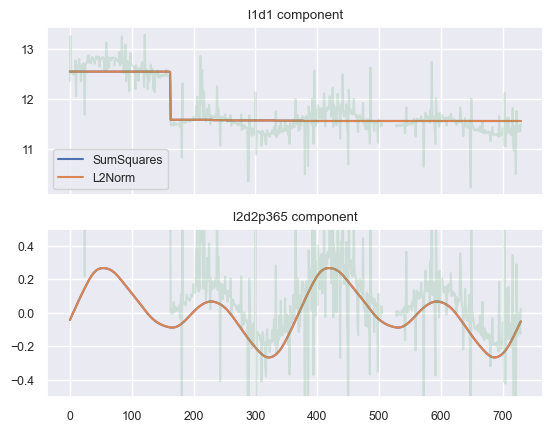

In [50]:
cvx_ss = cvx_sd(metric, c1=6, c2=results["weight_min"], use_ixs=use_ixs, solver="MOSEK")

# approximate c1 weight from optimization  in module (c2 is fixed)
cvx_l2n = cvx_sd_l2norm(metric, c1=6, c2=200, use_ixs=use_ixs, solver="MOSEK")

print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss[0], cvx_l2n[0]):.2e}')
print(f'MAE s_seas (OSD,CVX)   {mae(cvx_ss[1], cvx_l2n[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(cvx_ss[0], label="SumSquares")
ax1.plot(cvx_l2n[0], label="L2Norm")
ax1.plot(metric, alpha=0.2)
ax1.set_title("l1d1 component")
ax2.plot(cvx_ss[1])
ax2.plot(cvx_l2n[1])
ax2.plot(metric-metric[-3], alpha=0.2)
ax2.set_ylim(-0.5, 0.5)
ax2.set_title("l2d2p365 component")
ax1.legend()
plt.show()

In [51]:
print(results["weight_min"])

26327.411603701363
